## Configure Pyspark

In [21]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [22]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()

In [23]:
!pip install sparknlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import numpy as np
import json

import sparknlp
import pyspark.sql.functions as F

from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [25]:
import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [27]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

## Read in data

In [28]:
from pyspark.sql.functions import *
spark = sparknlp.start()

In [29]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
filePath = "drive/MyDrive/Colab Notebooks/comments.csv.xls"
comments_df = spark.read.format("csv").option("header","true").load(filePath)

In [50]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [52]:
def remove_stopwords(x):    
    string = ''
    if x is not None:
      for x in x.split(' '):
          if x.lower() not in stopwords:
              string += x + ' '
          else:
              pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)
comments_df = comments_df.withColumn('text_nosw',nosw('comment_text'))

In [46]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- text_nosw: string (nullable = true)
 |-- sentiment: double (nullable = true)



In [54]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0] if x is not None else None)
spark.udf.register("sentiment", sentiment)
comments_df = comments_df.withColumn('sentiment',sentiment('text_nosw').cast('double'))

In [55]:
comments_df.select('sentiment').show()

+--------------------+
|           sentiment|
+--------------------+
|                 0.3|
|                 0.1|
|                 0.0|
|                 0.0|
|                 0.0|
| 0.29166666666666663|
|0.005555555555555554|
|                 0.8|
|                 0.0|
|                 0.5|
|                 0.0|
|-0.09062499999999996|
|  0.6000000000000001|
|                 0.5|
|                 0.0|
|                 0.5|
|                 1.0|
|                 0.5|
|                 0.0|
|                0.25|
+--------------------+
only showing top 20 rows



In [56]:
# print average sentiment
comments_df.select(mean('sentiment')).collect()

[Row(avg(sentiment)=0.18128110201875783)]

In [57]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
# Create some plots
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

<Axes: xlabel='bin'>

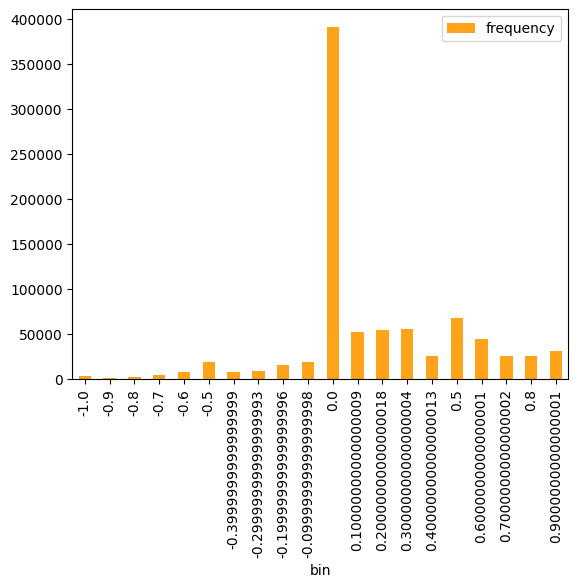

In [60]:
# plot sentiment in a histogram
# Using the RDD 

hist = comments_df.select('sentiment').rdd.flatMap(lambda x: x).histogram(20)

In [91]:
# Load the Computed Histogram into a Pandas Dataframe for plotting
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Create the DataFrame
df = pd.DataFrame(list(zip(*hist)), columns=['bin', 'frequency'])

In [92]:
df = df.round(3)

In [96]:
df = df.set_index('bin')
df

,frequency
bin,
-1.00,2785
-0.90,1326
-0.80,1753
-0.70,3751
-0.60,7409
-0.50,19259
-0.40,7364
-0.30,9111
-0.20,15653


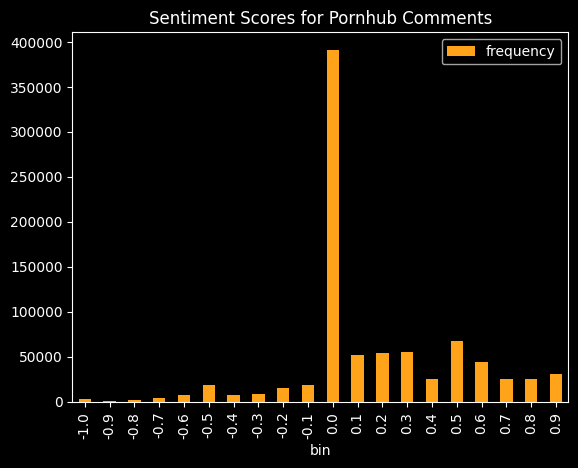

In [97]:
# Set the background color to black
plt.style.use('dark_background')

# Create the bar plot with a black background
ax = df.plot(kind='bar', color='#ffa31a')

# Set the color of the ticks and labels to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Set the title color to white
ax.set_title('Sentiment Scores for Pornhub Comments')
ax.title.set_color('white')

# Show the plot
plt.show();